In [191]:
#CHANGES
from google.cloud import bigquery
import pandas as pd
import numpy as np
import os
import google.auth
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split,GridSearchCV
import xgboost as xgb
import matplotlib.pyplot as plt 


pd.set_option('display.max_rows', 99)
pd.set_option('display.max_columns', 99)
pd.set_option('display.width', 1000)


In [192]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]='C:\\Users\\andriy.zmeul\\AppData\\Roaming\\gcloud\\legacy_credentials\\andriy.zmeul@gamigo.com\\adc.json'
credentials, project = google.auth.default()
client = bigquery.Client(credentials=credentials,project="business-intelligence-196814")
sql = """
with t0 as(
select product_name
,account_id
,date(reg_date) reg_date
from(
select product.name product_name
,account_id
,min(login_date) reg_date 
from `business-intelligence-196814.03_aggregation.login_activity_trion`
where product.name = 'TROVELIVE'
and login_date >='2021-01-01' and first_login=1
group by 1,2
)
)
,t1 as(
select reg_date
,count(distinct account_id) u
from(
select product.name product_name
,account_id
,min(login_date) reg_date 
from `business-intelligence-196814.03_aggregation.login_activity_trion`
where product.name = 'TROVELIVE'
and login_date >='2021-01-01' 
and first_login=1
group by 1,2
)
group by 1 
)
select reg_date
,days
,rev/u ltv
,rev
,u
from(
select g0.reg_date
,days
,u
,sum(rev) over (partition by g0.reg_date order by g0.reg_date,days) rev
from(
select reg_date
,date_diff(spend_date,reg_date, day) days
,sum(net_eur_amount) rev
from `business-intelligence-196814.03_aggregation.spend_activity_trion` e
inner join t0 on t0.account_id=e.customer_id and e.product.name=t0.product_name
where product.name = 'TROVELIVE'
and spend_date>='2021-01-01'
and reg_date<='2021-09-01'
and spend_date>=reg_date
group by 1,2
)g0
inner join t1 on t1.reg_date=g0.reg_date
)
where days<401
order by 1,2
"""

query_job = client.query(sql)
df = query_job.to_dataframe()

In [193]:
df0=df.loc[df['days'].isin(list(range(0,31)))]
df0=pd.pivot_table(df0, values='ltv', index=['reg_date'],
                    columns=['days'], aggfunc=np.sum).fillna(method='ffill',axis=1)
#df0.columns = ['day_0', 'day_1','day_2','day_3','day_4','day_5','day_6','day_7','day_8','day_9','day_10','day_11','day_12','day_13','day_14','day_15','day_16','day_17','day_18','day_19','day_20']

In [194]:
df0

days,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
reg_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-01,0.079670278,0.172943947,0.226933585,0.261262365,0.300423928,0.323674046,0.333358455,0.341300047,0.373523316,0.376787565,0.386490815,0.404832784,0.404832784,0.417178521,0.429345266,0.453155911,0.468101743,0.472585963,0.472585963,0.477121997,0.477121997,0.477121997,0.477121997,0.481662741,0.481662741,0.481662741,0.489576072,0.489576072,0.489576072,0.489576072,0.489576072
2021-01-02,0.120730412,0.207574148,0.274962373,0.308016822,0.385276671,0.409251881,0.449070385,0.456684374,0.468052236,0.472133687,0.481956618,0.520154936,0.522886233,0.524710049,0.530956175,0.533324480,0.577118194,0.602505533,0.604285082,0.605993803,0.613806994,0.616352368,0.618167331,0.656768482,0.656768482,0.667702523,0.677534307,0.682651616,0.689942452,0.689942452,0.697233289
2021-01-03,0.109818676,0.183495014,0.261396192,0.295435177,0.324324569,0.356600181,0.371473255,0.374786945,0.380924751,0.392098821,0.393748867,0.393748867,0.394120580,0.407946510,0.420167724,0.427679057,0.431618314,0.432175884,0.435902085,0.435902085,0.439628286,0.439628286,0.439628286,0.439628286,0.439628286,0.439628286,0.439628286,0.440000000,0.440000000,0.440000000,0.440000000
2021-01-04,0.100913416,0.183901047,0.262388202,0.308805899,0.366255947,0.400204567,0.409852521,0.417673644,0.433396765,0.436712655,0.440428164,0.473596575,0.491327307,0.491327307,0.491327307,0.503263559,0.505808754,0.510880114,0.529548049,0.533458611,0.533458611,0.537369172,0.537369172,0.545589914,0.553439581,0.553439581,0.553829686,0.553829686,0.565580400,0.565580400,0.565580400
2021-01-05,0.100388074,0.168362518,0.220056791,0.292494084,0.320993848,0.364254614,0.396194983,0.434865121,0.466109796,0.479171794,0.488338855,0.504529106,0.504917179,0.504917179,0.510761950,0.510761950,0.511145291,0.511145291,0.514784666,0.528826313,0.528826313,0.549469948,0.549469948,0.564051112,0.567960246,0.567960246,0.577415996,0.577415996,0.577415996,0.580927591,0.580927591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-28,0.163562193,0.296625056,0.452835488,0.519331253,0.597284886,0.691631743,0.732139991,0.787284886,0.851805617,0.912982613,0.954703522,1.030597414,1.126428890,1.229674543,1.232915738,1.238559964,1.295220687,1.300035667,1.307721801,1.308274632,1.308274632,1.310164958,1.315140437,1.315140437,1.326558181,1.333985733,1.345675435,1.347574677,1.360945163,1.360945163,1.363602318
2021-08-29,0.102799189,0.222235294,0.290446247,0.324839757,0.347983773,0.430141988,0.435643002,0.473241379,0.492458418,0.504778905,0.505886410,0.546726166,0.612154158,0.621655172,0.654888438,0.663383367,0.671383367,0.673955375,0.699083164,0.727529412,0.734636917,0.756592292,0.766417850,0.772296146,0.773983773,0.791922921,0.792535497,0.799456389,0.809728195,0.813878296,0.823237323
2021-08-30,0.071649089,0.191960690,0.254031640,0.331255992,0.380647172,0.408744008,0.418628955,0.448010547,0.461174497,0.477128476,0.477531160,0.477531160,0.480278044,0.487933845,0.488537872,0.489141898,0.506188878,0.506188878,0.506188878,0.508624161,0.512066155,0.512066155,0.521936721,0.525186961,0.525186961,0.538374880,0.538374880,0.542459252,0.545230105,0.545230105,0.549328859


In [195]:
df1=df.loc[df['days'].isin(list(range(340,380)))]
df1=df1.iloc[:,[0,2]]
df1=df1.groupby(['reg_date']).mean()
df1.head(n=600)

,ltv
reg_date,
2021-01-01,1.115470
2021-01-02,1.146304
2021-01-03,0.569045
2021-01-04,0.771622
2021-01-05,0.923173
...,...
2021-08-26,1.124570
2021-08-27,1.093612
2021-08-28,1.840219


In [196]:
#pd.merge(df0, df1, left_on='reg_date', right_on='reg_date', how='inner').drop('reg_date1', axis=1)
tb=df0.join(df1)

In [197]:
tb=tb.dropna(how='any')
tb=tb.apply(pd.to_numeric)

In [198]:
X=tb.drop(['ltv'], axis=1)
X=X.reset_index(drop=True)
y=tb.ltv
y=y.reset_index(drop=True)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

xgbr = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

xgbr.fit(x_train, y_train)

score = xgbr.score(x_train, y_train)  

print("Training score: ", score)

scores = cross_val_score(xgbr, x_train, y_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, x_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

Training score:  0.9999991658195755
Mean cross-validation score: 0.53
K-fold CV average score: 0.59


In [199]:
y_pred = xgbr.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 0.17
RMSE: 0.41


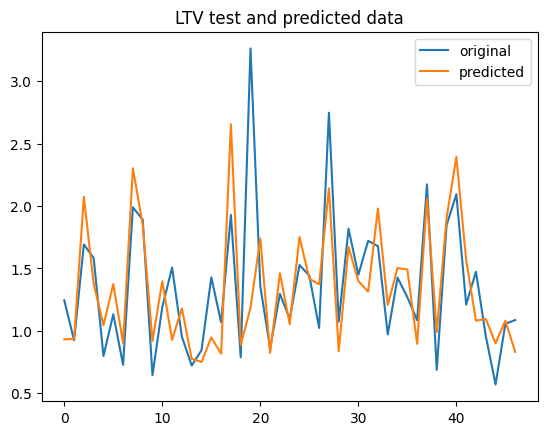

In [200]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("LTV test and predicted data")
plt.legend()
plt.show()

In [201]:
y_pred=xgbr.predict(x_test)
mse

0.17196992674076997

In [202]:
sql = """
with t0 as(
select product_name
,account_id
,date(reg_date) reg_date
from(
select product.name product_name
,account_id
,min(login_date) reg_date 
from `business-intelligence-196814.03_aggregation.login_activity_trion`
where product.name = 'TROVELIVE'
and login_date between '2022-07-01' and '2022-07-31'
and first_login=1
group by 1,2
)
)
,t1 as(
select reg_date
,count(distinct account_id) u
from(
select product.name product_name
,account_id
,min(login_date) reg_date 
from `business-intelligence-196814.03_aggregation.login_activity_trion`
where product.name = 'TROVELIVE'
and login_date between '2022-07-01' and '2022-07-31'
and first_login=1
group by 1,2
)
group by 1 
)
select reg_date
,days
,rev/u ltv
from(
select g0.reg_date
,days
,u
,sum(rev) over (partition by g0.reg_date order by g0.reg_date,days) rev
from(
select reg_date
,date_diff(spend_date,reg_date, day) days
,sum(net_eur_amount) rev
from `business-intelligence-196814.03_aggregation.spend_activity_trion` e
inner join t0 on t0.account_id=e.customer_id and e.product.name=t0.product_name
where product.name = 'TROVELIVE'
and spend_date>='2022-07-01'
and reg_date between '2022-07-01' and '2022-07-31'
and spend_date>=reg_date
group by 1,2
)g0
inner join t1 on t1.reg_date=g0.reg_date
)
where days<401
order by 1,2
"""

query_job = client.query(sql)
df_actual = query_job.to_dataframe()

In [203]:
dfa=df_actual.loc[df_actual['days'].isin(list(range(0,31)))]
dfa=pd.pivot_table(dfa, values='ltv', index=['reg_date'],columns=['days'], aggfunc=np.sum).fillna(method='ffill',axis=1)

In [204]:
dfa=dfa.dropna(how='any')
dfa=dfa.apply(pd.to_numeric)

In [205]:
dfa

days,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
reg_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-07-01,0.143973,0.263665,0.358729,0.415502,0.512597,0.537265,0.595000,0.643766,0.660276,0.717284,0.765479,0.812804,0.859042,0.861745,0.869664,0.869664,0.880460,0.880912,0.924982,0.926100,0.932274,0.932274,0.954862,0.954862,0.954862,0.968352,1.040304,1.074305,1.074305,1.076128,1.078402
2022-07-02,0.100432,0.220383,0.300624,0.338262,0.369875,0.395609,0.420844,0.447410,0.452254,0.468387,0.525393,0.534628,0.539692,0.539692,0.561372,0.570536,0.595314,0.595917,0.612715,0.618416,0.618416,0.621667,0.657871,0.662553,0.662553,0.662553,0.662553,0.663593,0.674179,0.688133,0.712990
2022-07-03,0.122681,0.247612,0.281277,0.303862,0.327850,0.464981,0.622277,0.641365,0.642335,0.696665,0.703504,0.716858,0.775277,0.829165,0.845758,0.850262,0.856512,0.973904,1.008738,1.146365,1.149185,1.149185,1.173335,1.175208,1.178435,1.190150,1.203254,1.203254,1.203815,1.203815,1.318350
2022-07-04,0.263417,0.381481,0.462806,0.521847,0.623541,0.703109,0.814206,0.875803,0.912462,0.928782,0.976967,0.984202,1.010040,1.054933,1.103907,1.134121,1.249344,1.291293,1.302217,1.315343,1.334701,1.389353,1.406137,1.406137,1.416543,1.440963,1.440963,1.483519,1.505937,1.509652,1.526472
2022-07-05,0.133789,0.214124,0.303854,0.372966,0.440748,0.473789,0.496653,0.539521,0.549647,0.549647,0.550335,0.573440,0.588675,0.611767,0.611767,0.784775,0.794784,0.817550,0.817550,0.823696,0.835314,0.838489,0.838489,0.838489,0.871311,0.906695,0.908968,0.908968,0.921213,0.921892,0.925081
2022-07-06,0.180739,0.409808,0.598418,0.754066,0.952942,0.982859,1.061878,1.112006,1.135007,1.203061,1.284352,1.340670,1.365155,1.467600,1.688615,1.749049,1.775791,1.788117,1.820133,1.872602,1.946358,1.946358,1.954239,2.039581,2.070256,2.077501,2.113741,2.192735,2.192735,2.192735,2.193322
2022-07-07,0.137762,0.284385,0.385572,0.447816,0.516889,0.567382,0.633827,0.640374,0.719772,0.736721,0.737252,0.742634,0.751182,0.787946,0.796965,0.813637,0.841263,0.841263,0.887247,0.901415,0.903615,0.906282,0.906282,0.906282,0.914244,0.914244,0.915035,0.930726,0.934173,0.934173,0.934965
2022-07-08,0.241296,0.400110,0.563427,0.635143,0.677444,0.698661,0.722623,0.747541,0.767900,0.778332,0.792520,0.805630,0.824729,0.824729,0.824729,0.825618,0.825618,0.827097,0.827097,0.827097,0.829233,0.830128,0.833615,0.833615,0.833615,0.833615,0.833615,0.833615,0.839586,0.839586,0.839586
2022-07-09,0.218884,0.302714,0.417767,0.493851,0.525743,0.537399,0.587356,0.604391,0.627452,0.631213,0.633814,0.759834,0.779348,0.779348,0.787212,0.787837,0.792041,0.818130,0.818654,0.818654,0.818654,0.818654,0.818654,0.827548,0.827548,0.836421,0.839038,0.891501,0.892142,0.892142,0.892142


In [206]:
xgbr.predict(dfa)

array([1.526939 , 1.08232  , 2.1384304, 1.9468987, 1.3986601, 2.3927195,
       1.4291486, 1.2082689, 1.3214412, 1.5469378, 2.0574963, 2.7990263,
       2.472923 , 1.6340117, 1.3870128, 2.0706093, 2.0152955, 1.0305383,
       2.5292265, 1.6965501, 1.155379 , 1.3557405, 2.0586414, 2.5853112,
       1.9601326, 2.2668388, 2.6246426, 2.4582248, 1.8523471, 1.5928141,
       2.2735698], dtype=float32)

In [188]:
def greet(name):
    """
    This function greets to
    the person passed in as
    a parameter
    """
    print("Hello, " + name + ". Good morning!")

In [190]:
greet("pussy juissy")

Hello, pussy juissy. Good morning!
